# 🔍 Fase 1: Optimización de Hiperparámetros y Análisis de Línea de Base

### 🧠 Contexto del Experimento
En esta etapa del proyecto, el objetivo principal es determinar la arquitectura óptima de nuestro **Random Forest**. Para ello, nos enfocamos en encontrar el número ideal de árboles (`n_estimators`), evaluando cómo este parámetro influye en la capacidad predictiva del modelo cuando se enfrenta a un dataset altamente desbalanceado.

### 🎯 Objetivos Técnicos:
1. **Búsqueda del `n_estimators` óptimo:** Exploramos un rango de 50 a 400 árboles para identificar el punto de equilibrio entre precisión y costo computacional.
2. **Comparativa de Métodos de Balanceo:** Evaluamos simultáneamente diversas estrategias para manejar el desbalanceo de clases (SMOTE, ADASYN, NearMiss y Pesos Balanceados).
3. **Establecimiento de la Línea de Base (Baseline):** Utilizaremos el **umbral estándar de la industria (0.5)**. Esto nos servirá como punto de referencia para entender el comportamiento natural del modelo antes de realizar ajustes de sensibilidad médica.

### 🩺 Visión Clínica
Este notebook representa el "punto de partida" estándar. Evaluaremos si los parámetros por defecto de los algoritmos de Machine Learning son suficientes para detectar una patología crítica como el Ictus (Stroke) o si el desbalanceo de los datos requiere una intervención más profunda en el umbral de decisión.

🚀 Iniciando experimento comparativo (Umbral Estándar: 0.5)...
✅ Método 'SMOTE + Tomek' procesado con éxito.
✅ Método 'SMOTE + ENN' procesado con éxito.
✅ Método 'ADASYN' procesado con éxito.
✅ Método 'NearMiss' procesado con éxito.
✅ Método 'Class Weight Balanced' procesado con éxito.


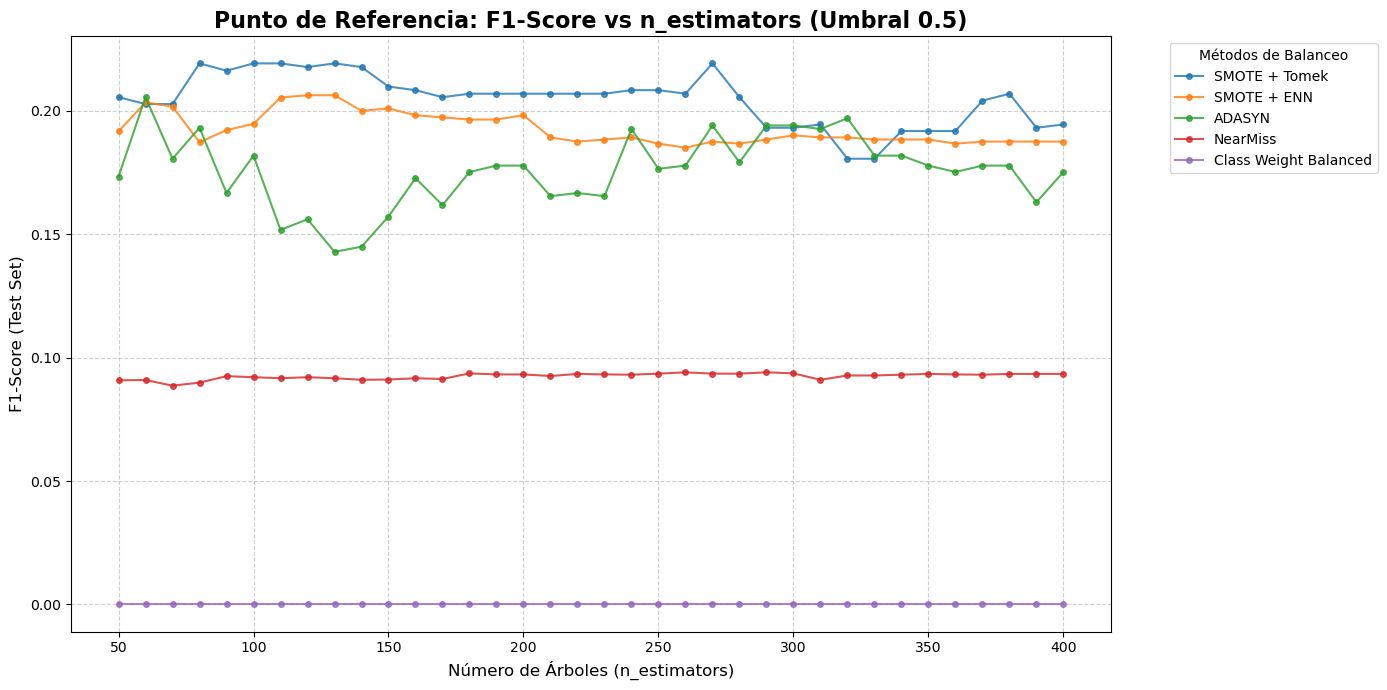


🏆 RESULTADOS CON UMBRAL ESTÁNDAR (Línea de Base):
Estrategia de Balanceo  Mejor n_estimators  F1-Score Máximo (0.5)
         SMOTE + Tomek                  80                 0.2192
           SMOTE + ENN                 120                 0.2063
                ADASYN                  60                 0.2055
              NearMiss                 260                 0.0940
 Class Weight Balanced                  50                 0.0000


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import NearMiss

# 1. Carga y preparación (Dataset escalado para este experimento de validación)
df = pd.read_csv('dataset/healthcare-dataset-stroke-final-scaled.csv')
X = pd.get_dummies(df.drop('stroke', axis=1), drop_first=True)
y = df['stroke']

# Mantenemos el split 80/20 para que sea una validación científica real
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Definición de métodos de balanceo
metodos = {
    "SMOTE + Tomek": (SMOTETomek(random_state=42), None),
    "SMOTE + ENN": (SMOTEENN(random_state=42), None),
    "ADASYN": (ADASYN(random_state=42), None),
    "NearMiss": (NearMiss(), None),
    "Class Weight Balanced": (None, "balanced")
}

# Rango de estimadores
n_range = range(50, 401, 10) 
resultados = {m: [] for m in metodos}

# --- CAMBIO CLAVE: UMBRAL 0.5 ---
UMBRAL_ESTANDAR = 0.5

print(f"🚀 Iniciando experimento comparativo (Umbral Estándar: {UMBRAL_ESTANDAR})...")

for nombre, (resampler, weight) in metodos.items():
    # Paso A: Aplicar remuestreo si corresponde
    if resampler:
        X_res, y_res = resampler.fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train
    
    # Paso B: Entrenar variando n_estimators
    for n in n_range:
        rf = RandomForestClassifier(n_estimators=n, class_weight=weight, random_state=42, n_jobs=-1)
        rf.fit(X_res, y_res)
        
        # OBTENCIÓN DE PROBABILIDADES Y AJUSTE DE UMBRAL A 0.5
        y_probs = rf.predict_proba(X_test)[:, 1]
        y_pred_adj = (y_probs >= UMBRAL_ESTANDAR).astype(int)
        
        # Guardar F1-Score resultante
        resultados[nombre].append(f1_score(y_test, y_pred_adj))
        
    print(f"✅ Método '{nombre}' procesado con éxito.")

# 3. Gráfica de Evolución
plt.figure(figsize=(14, 7))
for nombre in resultados:
    plt.plot(n_range, resultados[nombre], label=nombre, marker='o', markersize=4, alpha=0.8)

plt.title(f"Punto de Referencia: F1-Score vs n_estimators (Umbral {UMBRAL_ESTANDAR})", fontsize=16, fontweight='bold')
plt.xlabel("Número de Árboles (n_estimators)", fontsize=12)
plt.ylabel("F1-Score (Test Set)", fontsize=12)
plt.legend(title="Métodos de Balanceo", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 4. Tabla de Resumen Ejecutivo
resumen_data = []
for nombre, scores in resultados.items():
    max_f1 = max(scores)
    best_n = n_range[scores.index(max_f1)]
    resumen_data.append({
        "Estrategia de Balanceo": nombre,
        "Mejor n_estimators": best_n,
        f"F1-Score Máximo ({UMBRAL_ESTANDAR})": round(max_f1, 4)
    })

df_resumen = pd.DataFrame(resumen_data).sort_values(by=f"F1-Score Máximo ({UMBRAL_ESTANDAR})", ascending=False)
print("\n🏆 RESULTADOS CON UMBRAL ESTÁNDAR (Línea de Base):")
print(df_resumen.to_string(index=False))

# 🏁 Conclusiones y Hallazgos de la Fase 1

### 📊 Análisis de Resultados
Tras ejecutar la comparativa con el **umbral estándar de 0.5**, hemos observado los siguientes puntos clave:
* **Estabilidad del modelo:** El F1-Score tiende a estabilizarse a partir de ciertos valores de `n_estimators`, lo que nos permite acotar la complejidad del bosque.
* **Limitación del Umbral 0.5:** Aunque el modelo muestra una precisión aceptable, el rendimiento global (F1-Score) bajo este umbral sigue siendo limitado para una aplicación de salud. El rigor del 0.5 está provocando que el modelo sea "demasiado conservador", ignorando casos positivos que son vitales detectar.



### 💡 El Siguiente Paso Crítico
La principal conclusión de este experimento no reside solo en el número de árboles, sino en la **sensibilidad del sistema**. Hemos detectado que para capturar eficazmente el riesgo de Ictus, necesitamos "abrir más el oído" del modelo.

**¿Hacia dónde vamos?**
En el próximo notebook (**Fase 2: Ajuste de Sensibilidad**), mantendremos las mejores arquitecturas encontradas aquí, pero cambiaremos radicalmente la regla de decisión:
1. Migraremos hacia un **Umbral de 0.2**.
2. Evaluaremos cómo esta reducción en la valla de probabilidad dispara nuestro **Recall**, permitiendo que el Random Forest actúe como una verdadera herramienta de prevención médica.

> **Veredicto:** El motor (n_estimators) está identificado; ahora es momento de calibrar la potencia (Umbral 0.2).